____

**project**: `Mango Leaf Disease Classification`

**date**: `2023-07-03`

**decription**: `This notebook represents a classification model that classifies 7 different mango leaf diseases and a health class using Deep Neural Networks`.

**main**: `computer vision(cv) pytorch`

**architecture**:  `VGG_19`

**language**: `python`

**programer**: `crispengari`
____


### Data
In this notebook we will train a simple image classification model that does a simple multi-class mango leaf disease classification task based on the dataset that was obtained from [kaggle](https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset). So our goal in this notebook is to create a model using `Deep Neural Networks` that accurately predicts `7` different mango leafs disease classes and `1` health class.

> This image dataset showcases 8 classes which include


1. `Anthracnose`
2. `Bacterial Canker`
3. `Cutting Weevil`
4. `Die Back`
5. `Gall Midge`
6. `Powdery Mildew`
7. `Sooty Mould`
8. `Healthy`


### Model Architecture

In this notebook we will create a image clasifier model that will classify `8` diffent types of melonoma. So basically this is a multi-class classification problem which will be able to do skin cancer detection. We will use the [`VGG`](https://arxiv.org/abs/1409.1556) achitecture. VGG is a neural network model that uses convolutional neural network (`CNN`) layers and was designed for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/), which it won in `2014`.

The commonly used `VGG` variants are `VGG11`, `VGG13` and `VGG19`, which correspond to configurations `"A"`, `"B"`, and `"E"`. Configurations `"A-LRN"` and `"C"` - which is the same as `"D"` but with smaller filter sizes in some convolutional layers - which are rarely used.

This notebook we are going to focus on the `E` configuration of `VGG` which is called `VGG19`. We are not going to train our model from scratch we are going to use a well known strategy in deep learning called `transfare-learning` the `VGG19` achitecture looks as follows:

![alt](https://www.researchgate.net/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg)


### Transfare Leaning

The act of using a pre-trained model is generally known as transfer learning, as we are learning to transfer knowledge from one task to another. It is also referred to as fine-tuning, as we fine-tune our parameters trained on one task to the new, downstream task. The terms transfer learning and fine-tuning are used interchangably in machine learning.

This means we don't have to learn them from scratch when using the pre-trained model for our task, causing our model to converge earlier. We can also think of the pre-trained model as being a very good set of weights to initialize our model from, and using pre-trained models usually leads to a performance improvement compared to initializing our weights randomly.

Usually we will initialize our weights randomly - following some weight initialization scheme - and then train our model. Using a pre-trained model means some - potentially all - of our model's weights are not initialized randomly, but instead taken from a copy of our model that has already been trained on some task. The task the model has been pre-trained on does not necessarily have to match the "downstream task" - the task we want to use the pre-trained model on. For example, a model that has been trained to classify images can then be used to detect objects within an image.

### Installing Helper Packages

In the following code cell we are going to install the package called `helperfns` that provide us with some usefull helper functions for machine learning.

We are also going to install `kaggle` which will allow us to interact with kaggle datasets, so that we can download the dataset that we want from kaggle.


In [1]:
!pip install helperfns kaggle -q

  Preparing metadata (setup.py) ... done


### Imports
In the following code cell we are going to import all the packages that we are going to use throughout this notebook.

In [2]:
import torch
import random
import os
import time
import torchvision
import copy
import shutil

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils import data
from PIL import Image
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from sklearn import decomposition, manifold
from helperfns.tables import tabulate_data
from helperfns.visualization import plot_complicated_confusion_matrix, plot_simple_confusion_matrix
from helperfns.torch import models
from helperfns.utils import hms_string


torch.__version__

'2.0.1+cu118'

### Seed
In the following code cell we are going to set-up the `SEED` for reproducivity in this notebook.

In [3]:
SEED = 23

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device
In the following code cell we are going to get the `gpu` as our device if possible for training speed.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Data

As we mentioned the dataset that we are going to use is from `kaggle` we need a way of downloading and extracting it from `kaggle`. We will follow the steps that we listed on one of my previous notebooks [05_ResNet.ipynb](https://github.com/CrispenGari/pytorch-python/blob/main/03_Torch_Vision/03_Image_Classification/05_ResNet.ipynb).

In [5]:
os.environ["KAGGLE_USERNAME"]= "YOUR_USERNAME"
os.environ['KAGGLE_KEY'] = "YOUR_KAGGLE_KEY"

In [6]:
!kaggle datasets download aryashah2k/mango-leaf-disease-dataset --unzip

 99% 102M/103M [00:06<00:00, 23.5MB/s] 
100% 103M/103M [00:06<00:00, 17.8MB/s]


To handle our dataset we are going to use the torch-vision class called `dataset.ImageFolder` and it expect the folder structure looks as follows:

```
📂set (train|test|validation)
 📂 classx
    🖼 x.png
    🖼 x.jpg
  ....

 📂 classy
    🖼 x.png
    🖼 x.jpg
    ...

*** KEY
🖼 x.png - is an image that belongs to class x.

```

Our dataset is not in that format. So we will need to write a script that will automate the creation of the dataset in a way that we want. We will need to generate the following sets

1. `train`
2. `test`

In [7]:
BASE_DIR = "."
SAVE_DIR = os.path.join(BASE_DIR, 'mango_leaves')
IMAGES_DIR = BASE_DIR
TRAIN_RATIO = .90

TRAIN_DIR = os.path.join(SAVE_DIR, 'train')
TEST_DIR = os.path.join(SAVE_DIR, 'test')

if not os.path.exists(SAVE_DIR):
  os.makedirs(SAVE_DIR)

if not os.path.exists(TRAIN_DIR):
  os.makedirs(TRAIN_DIR)

if not os.path.exists(TEST_DIR):
  os.makedirs(TEST_DIR)


for folder in os.listdir(IMAGES_DIR):
  if folder not in ['Sooty Mould', 'Gall Midge','Anthracnose', 'Die Back', 'Powdery Mildew', 'Bacterial Canker', 'Healthy', 'Cutting Weevil']:
    continue
  class_ = folder.lower()
  class_save_dir_train = os.path.join(TRAIN_DIR, class_)
  if not os.path.exists(class_save_dir_train):
     os.makedirs(class_save_dir_train)

  class_save_dir_test = os.path.join(TEST_DIR, class_)
  if not os.path.exists(class_save_dir_test):
      os.makedirs(class_save_dir_test)

  images_location = os.path.join(IMAGES_DIR, folder)
  images = os.listdir(images_location)
  train_count = int(TRAIN_RATIO * len(images))
  for i, image in enumerate(images[:train_count]):
    ext = image.split('.')[-1]
    image_name = f'{i}.{ext}'
    try:
        Image.open(os.path.join(images_location, image))
        shutil.move(os.path.join(images_location, image), os.path.join(class_save_dir_train, image_name))
    except Exception as e:
      pass
  for i, image in enumerate(images[train_count:]):
    ext = image.split('.')[-1]
    image_name = f'{i}.{ext}'
    try:
      Image.open(os.path.join(images_location, image))
      shutil.move(os.path.join(images_location, image), os.path.join(class_save_dir_test, image_name))
    except:
      pass

print('*** Automation Done!!')

*** Automation Done!!


We are going to take a fraction from the `train` data to come up with our `valid` data.

First let's define our base path to the images.

In [8]:
base_path = SAVE_DIR

### Image Transformations

We are going to be using a pre-trained model we will need to ensure that our images are the same size and have the same normalization as those used to train the model - which we find on the torchvision [models](https://nbviewer.jupyter.org/github/bentrevett/pytorch-image-classification/blob/master/5_resnet.ipynb) page.

> Note that the validation and the test transforms are the same.

In [9]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

image_transforms = {
    "train": transforms.Compose([
            transforms.Resize(pretrained_size),
            transforms.RandomRotation(5),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomCrop(pretrained_size, padding = 10),
            transforms.ToTensor(),
            transforms.Normalize(mean = pretrained_means,
                                std = pretrained_stds)
          ]),
    "valid": transforms.Compose([
          transforms.Resize(pretrained_size),
          transforms.CenterCrop(pretrained_size),
          transforms.ToTensor(),
          transforms.Normalize(mean = pretrained_means,
                            std = pretrained_stds)
        ]),
    "test": transforms.Compose([
          transforms.Resize(pretrained_size),
          transforms.CenterCrop(pretrained_size),
          transforms.ToTensor(),
          transforms.Normalize(mean = pretrained_means,
                            std = pretrained_stds)
    ])
}

### Loading our custom Data

Next we are going to create an image_dataset using the `datasets.ImageFolder` from `torchvision` for  train and test sets.

In [10]:
image_datasets = {
    x.lower(): datasets.ImageFolder(
        os.path.join(base_path, x),
        transform = image_transforms[x.lower()]
    ) for x in os.listdir(base_path)
}

Let's get the class names in our dataset.

In [11]:
class_names = image_datasets["train"].classes
class_names

['anthracnose',
 'bacterial canker',
 'cutting weevil',
 'die back',
 'gall midge',
 'healthy',
 'powdery mildew',
 'sooty mould']

We can also get classes to index which shows us the classname pared to the integer representation of that class.

In [12]:
image_datasets['train'].class_to_idx

{'anthracnose': 0,
 'bacterial canker': 1,
 'cutting weevil': 2,
 'die back': 3,
 'gall midge': 4,
 'healthy': 5,
 'powdery mildew': 6,
 'sooty mould': 7}

Now we can create a validation data from the train set.

> Note that the validation data will come from the `train` set. We are going to take a ratio of `10%` and give it to the validation set and then the rest will remain in the train data.

In [13]:
train_data = image_datasets["train"]
test_data = image_datasets["test"]

VALID_RATIO = 0.7
n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

Overiding the transforms of the train on the validation set with the validation transforms that we have defined previously.

In [14]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = image_transforms['valid']

### Checking examples
In the following code cell we are going to count how many examples we are having from our dataset.

In [15]:
title = "DATASETS EXAMPLES"
columns = "SET", "TOTAL"
data_rows = [("training", len(train_data)),
             ("testing", len(test_data)),
             ("validation", len(valid_data)),
             ("total", f"{len(valid_data) + len(test_data) + len(train_data):,}")
        ]

tabulate_data(columns, data_rows, title)


DATASETS EXAMPLES
+------------+-------+
| SET        | TOTAL |
+------------+-------+
| training   |  2520 |
| testing    |   400 |
| validation |  1080 |
| total      | 4,000 |
+------------+-------+


### Iterator
In the following code cell we are then going to create an `iterator` with the batchsize of `64`

In [16]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(
    train_data, shuffle=True, batch_size= BATCH_SIZE
)
valid_iterator = data.DataLoader(
    valid_data, batch_size= BATCH_SIZE
)
test_iterator = data.DataLoader(
    test_data,  batch_size= BATCH_SIZE
)

### Visualizing Images
Now we can go ahead and visualize the images that we are having in this dataset.

In [17]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

In the following code cell we are going to define the `leaf_types`  as a lists for later usage.

In [18]:
leaf_types =[
    {'id': v, 'type': k} for k, v in image_datasets['train'].class_to_idx.items()
]
leaf_types

[{'id': 0, 'type': 'anthracnose'},
 {'id': 1, 'type': 'bacterial canker'},
 {'id': 2, 'type': 'cutting weevil'},
 {'id': 3, 'type': 'die back'},
 {'id': 4, 'type': 'gall midge'},
 {'id': 5, 'type': 'healthy'},
 {'id': 6, 'type': 'powdery mildew'},
 {'id': 7, 'type': 'sooty mould'}]

In the following code cell we are going to define a function that will plot the normalised images from our datasets.

In [19]:
def plot_images(images, labels, classes, normalize = True):
  n_images = len(images)
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize = (10, 10))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image = images[i]
    if normalize:
        image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(leaf_types[labels[i]]["type"], fontsize=7)
    ax.axis('off')

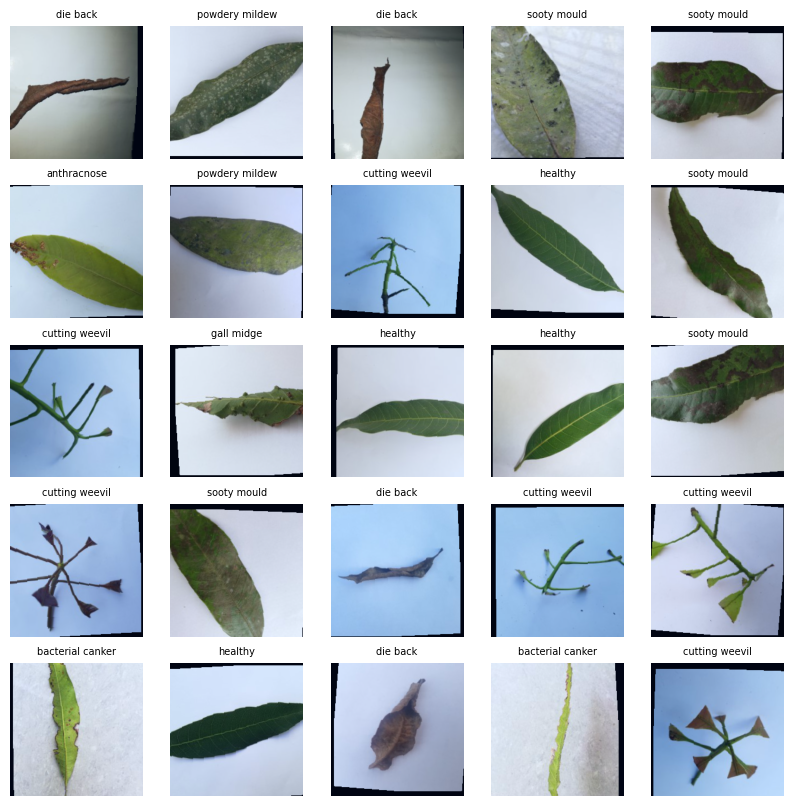

In [20]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in
                           [train_data[i] for i in range(N_IMAGES)]])
classes = test_data.classes
plot_images(images, labels, classes)

### Defining Model
As we said we will use the `VGG_19` model based on [this notebook](https://github.com/CrispenGari/pytorch-python/blob/main/03_Torch_Vision/03_Image_Classification/04_VGG.ipynb)
we are going to define our model achitecture in the code cells that follows.

Let's start by defining the `VGG` architecture in the following code cell:



In [21]:
class VGG(nn.Module):
  def __init__(self, features, output_dim):
    super().__init__()
    self.features = features
    self.avgpool = nn.AdaptiveAvgPool2d(7)

    self.classifier = nn.Sequential(
      nn.Linear(512 * 7 * 7, 4096),
      nn.ReLU(inplace = True),
      nn.Dropout(0.5),
      nn.Linear(4096, 4096),
      nn.ReLU(inplace = True),
      nn.Dropout(0.5),
      nn.Linear(4096, output_dim)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    h = x.view(x.shape[0], -1)
    x = self.classifier(h)
    return x, h

### `VGG_19` configuration
The `"E"` configuration which is also known as the `vgg19_config` is typically the VGG configurations are defined as lists. Each item in the list is either 'M', which denotes a max pooling layer, or an integer, which denotes a convolutional layer with that many filters.

In the following code cell we are going to define the `E` config.

In [22]:
E = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
                512, 512, 512, 512, 'M']

We can now define a function which takes in a configuration list and returns a `nn.Sequential` with the respective layers.

In [23]:
def get_vgg_layers(config, batch_norm):
  layers = []
  in_channels = 3
  for c in config:
    assert c == 'M' or isinstance(c, int)
    if c == 'M':
      layers += [nn.MaxPool2d(kernel_size = 2)]
    else:
      conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
      if batch_norm:
          layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
      else:
          layers += [conv2d, nn.ReLU(inplace = True)]
      in_channels = c
  return nn.Sequential(*layers)

Now, let's get the features for the `VGG19` architecture, with batch normalization.

In [24]:
vgg19_layers = get_vgg_layers(E, batch_norm = True)
print(vgg19_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

We can then pass these features to our base VGG module to get our `VGG19` model.

> Note that the output dimension is `8` in this case since this is a multi-class classification task.

In [25]:
OUTPUT_DIM = len(leaf_types)
mldc_model = VGG(vgg19_layers, OUTPUT_DIM).to(device)
mldc_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Counting model Parameters
In the following code cell we are going to count the `model` parameters of our model.

In [26]:
models.model_params(mldc_model)

TOTAL MODEL PARAMETERS: 	139,614,024
TOTAL TRAINABLE PARAMETERS: 	139,614,024


### Pretrained Models.

In this notebook I'm  actually not going to use a VGG model with parameters that have been randomly initialized VGG model. I'm going to be using a VGG model with pre-trained parameters. Using a pre-trained model involves initializing our model with parameters that have already been trained for a certain task - usually not the exact same task we are trying to do ourselves.

In [27]:
pretrained_model = torchvision.models.vgg19_bn(pretrained = True)
pretrained_model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:05<00:00, 107MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

We can count the pretrained model parameters as follows:


In [28]:
models.model_params(pretrained_model)

TOTAL MODEL PARAMETERS: 	143,678,248
TOTAL TRAINABLE PARAMETERS: 	143,678,248


### Fine Tuning
Our pretrained `VGG_19` model has `1000` output features of which we only have `8` classes in our dataset. We want to modify the last layer of our pretrained model so that it will have the output size based on our classes which is `8`.

In [29]:
IN_FEATURES = pretrained_model.classifier[-1].in_features
final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
final_fc

Linear(in_features=4096, out_features=8, bias=True)

We can directly overwrite the previous linear layer with our new linear layer.

In [30]:
pretrained_model.classifier[-1] = final_fc

We can then print out the classifier of our model to ensure the final linear layer now has an output dimension of `9`.

In [31]:
print(pretrained_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=8, bias=True)
)


We could go ahead and use the `pretrained_model` module from here on out, however it only returns the final output layer and not the intermediate representation as our model does. We can see that in the model's definition here.

We can load the parameters of the `pretrained_model` into our model by loading the parameters `(state_dict)` from the `pretrained_model` into our model in the same way we loaded the "best" saved parameters in some cases - by using `load_state_dict`. However, this time we load directly from the `pretrained_model` instead of using `torch.load` on the path of the saved model parameters.

This is only possible as our model has the exact same layers (order and shape) as the `pretrained_model` with the final linear layer replaced with our `8` dimensional output linear layer.

In [32]:
mldc_model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

We can also count the model parameters after loading the pretrained weigths as follows.

In [33]:
models.model_params(mldc_model)

TOTAL MODEL PARAMETERS: 	139,614,024
TOTAL TRAINABLE PARAMETERS: 	139,614,024


### Model Training
In the following code cell we are going to create create `optimizer` and `criterion`. Note that for the optimizer we are going to use the Adam with default parameters and `CrossEntropyLoss` as our loss function since it is a multi-class classification.

> Note that this loss functions expect labels to be `LongTensors` we will change them to `LongTensors` during training and evaluation.

In [34]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(mldc_model.parameters())

### Categorical Accuracy Function.
In the following code cell we are going to define our `categorical_accuracy` function which is a function that caculate the categorical accuracy between predicted labels and real labels.

In [35]:
def categorical_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/ y.shape[0]
  return acc

### Train and Evaluation Function

1. `train`
* first we put the model in the train mode by calling the `model.train()`
*. We will iterate over the iterator and put `labels` and features(`images`) to the `device`
*  we call the `optimizer.zero_grad()` to restore the gradients of the optimizer for each iteration
* we make predictions and calculate the `accuracy` and `loss`
* we then updates the weights by calling `optimizer.step()` after backward propergation using the `loss.backward()`
* we will return the `loss` and the `accuracy`

2. `evaluate`
* we put the model in evaluation mode by calling `model.eval()`
* we wrap our loop with `torch.no_grad()` beacuse we are not interested in calculating the gradients during model evaluation.
* We calculate the `loss` and `accuracy` and return them
Our train and evaluate function are as follows:

In [36]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.train()
  for (x, y) in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device).long()
    # Zero the gradients
    optimizer.zero_grad()
    y_pred, _ = model(x)
    # Calculate the loss and accuracy
    y_pred = y_pred.squeeze()

    loss = criterion(y_pred, y)
    acc = categorical_accuracy(y_pred, y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()
    epoch_loss +=loss.item()
    epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device).long()
      y_pred, _ = model(x)
      y_pred = y_pred.squeeze()
      loss = criterion(y_pred, y)
      acc = categorical_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

### Training loop
We are then going to run our training loop as save the model when the previous validation loss is less that the current validation loss. We are only going to train the model for `10` epochs. We are going to keep in track of the model training history so that we can visualize it later on.

In [37]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(elt)

Now we can run our train loop...

In [38]:
EPOCHS = 10
best_valid_loss = float('inf')
MODEL_NAME = "mldc_model.pt"
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
last_saved_epoch = 1

history = History()
training_start = time.time()

for epoch in range(EPOCHS):
  start = time.time()

  train_loss, train_acc = train(mldc_model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(mldc_model, valid_iterator, criterion, device)

  save_status = "(not saving)"
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    save_status = "(saving)"
    last_saved_epoch = epoch + 1
    torch.save(mldc_model.state_dict(), MODEL_NAME)

  end = time.time()
  history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)


  data_rows = [
      ["Train", f'{train_loss:.3f}', f'{train_acc * 100:.2f}%', hms_string(end-start)],
      ["Validation", f'{valid_loss:.3f}', f'{valid_acc * 100:.2f}%', ""]
  ]

  title = f"EPOCH {epoch+1:02}/{EPOCHS}: {save_status}"
  tabulate_data(column_names, data_rows, title)

training_end = time.time()

EPOCH 01/10: (saving)
EPOCH 01/10: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.864 |   73.71% | 0:01:16.81 |
| Validation | 9.215 |   71.36% |            |
+------------+-------+----------+------------+
EPOCH 02/10: (saving)
EPOCH 02/10: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.476 |   86.17% | 0:01:15.83 |
| Validation | 3.386 |   53.76% |            |
+------------+-------+----------+------------+
EPOCH 03/10: (saving)
EPOCH 03/10: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.233 |   92.75% | 0:01:19.78 |
| Validation | 0.221 |   94.71% |            |
+------------+-------+----------+------------+
EPOCH 04/10: (not savi

### Visualizing the training History
In this section of the notebook we are going to visualize the training history of the model over `N` epochs.

In [39]:
print("----- TOTAL TRAINING TIME ")
rows = [
      ["TOTAL EPOCHS", f'{EPOCHS}'],
      ["LAST SAVED EPOCH", f'{last_saved_epoch}'],
      ["TOTAL TRAINING TIME", f'{hms_string(training_end-training_start)}']
]
tabulate_data(['', 'value'], rows, "TOTAL TRAINING TIME")

----- TOTAL TRAINING TIME 
TOTAL TRAINING TIME
+---------------------+------------+
|                     |      value |
+---------------------+------------+
| TOTAL EPOCHS        |         10 |
| LAST SAVED EPOCH    |          9 |
| TOTAL TRAINING TIME | 0:12:13.03 |
+---------------------+------------+


Let's plot how long the model took to train each epoch from our `history` object.

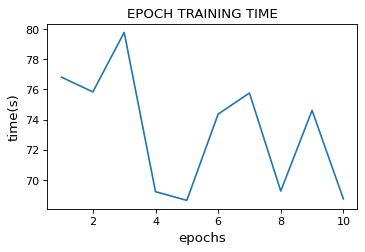

In [40]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.epoch_train_time)
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)
plt.show()

Let's plot the model's training history in terms of `acuracy` and `losses` over a period of `N` epochs in our `train` and `valid` sets.

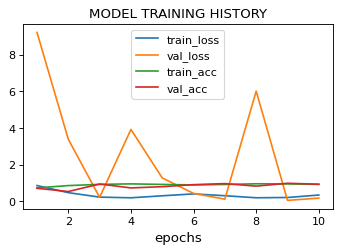

In [41]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_losses, label="train_loss")
plt.plot(epochs, history.val_losses, label="val_loss")
plt.plot(epochs, history.train_acc, label="train_acc")
plt.plot(epochs, history.val_acc, label="val_acc")
plt.title("MODEL TRAINING HISTORY", color="k", fontsize=12)
plt.legend()
plt.xlabel("epochs", fontsize=12)
plt.show()

Next we are going to `evaluate` the best model and check for the model `loss` and accuracy based on the `unseen` dataset which is the `test`.

In [42]:
mldc_model.load_state_dict(torch.load(MODEL_NAME))

test_loss, test_acc = evaluate(mldc_model, test_iterator, criterion, device)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]

tabulate_data(column_names, data_rows, title)

Model Evaluation Summary
Model Evaluation Summary
+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 0.092 |   97.54% |            |
+------+-------+----------+------------+


### Downloading the best model
We are going to download the saved model as a file in the following code cell.

In [43]:
from google.colab import files
files.download(MODEL_NAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model Inference
For model inference we are going to take in an image and make predictions on it.

### Image preprocessing
For image preprocessing we are going to use `torchvision` transforms so we are basically going to use the `test_transforms` which looks as follows:

```py
test_transforms = transforms.Compose([
  transforms.Resize(pretrained_size),
  transforms.CenterCrop(pretrained_size),
  transforms.ToTensor(),
  transforms.Normalize(mean = pretrained_means,
                    std = pretrained_stds)
])
```

First we will load the image using Python Image Libray (PIL) and transform it using the `test-transform` wich we defined later on. The `preprocess_img` function defined bellow does exactly that.

In [44]:
def preprocess_img(img):
  """
  takes in a pillow image and pre process it
  """
  img = image_transforms['test'](img)
  return img

In [46]:
img_path = os.path.join('mango_leaves',
                        "test/anthracnose/0.jpg")
pil_img = Image.open(img_path)
img = preprocess_img(pil_img)

### Predict method
The predict method will take in the following args:

1. model
2. image (processed image)
3. device (cuda or cpu)

In [47]:
class Prediction:
    def __init__(self, label:int, probability:float, type_: str) -> None:
        self.label = label
        self.probability = probability
        self.type_ = type_

    def __repr__(self) -> str:
        return f"[{self.type_}]"

    def __str__(self) -> str:
        return f"[{self.type_}]"

    def to_json(self):
        return {
            "label": int(self.label),
            "probability": float(self.probability),
            "type": self.type_,
        }

class Response:
    def __init__(self, top_prediction: Prediction, predictions:list) -> None:
        self.predictions = predictions
        self.top_prediction = top_prediction

    def __repr__(self) -> str:
        return f"[MANGO LEAF DISEASE Prediction Response - {self.top_prediction.type_}]"

    def __str__(self) -> str:
        return f"[MANGO LEAF DISEASE Prediction Response - {self.top_prediction.type_}]"

    def to_json(self):
        return{
           "predictions": [item.to_json() for item in self.predictions],
            "top_prediction": self.top_prediction.to_json()
        }


In [48]:
def predict(model, image, device):
  model.eval()
  with torch.no_grad():
    image = image.unsqueeze(dim=0).to(device)
    preds, _ = model(image)
    preds = F.softmax(preds, dim=1).detach().cpu().numpy().squeeze()
    predicted_label = np.argmax(preds)
    predictions = [
       Prediction(
            label= i,
            type_ = classes[i],
            probability = np.round(preds[i], 2)
        ) for i, _ in enumerate(preds)
    ]
    predicted = Prediction(
        label= predicted_label,
        type_ = classes[predicted_label],
        probability = np.round(preds[predicted_label], 2)
    )
    return Response(
        top_prediction = predicted,
        predictions = predictions
    )

In [49]:
predict(mldc_model, img, device).to_json()

{'predictions': [{'label': 0,
   'probability': 0.9200000166893005,
   'type': 'anthracnose'},
  {'label': 1,
   'probability': 0.029999999329447746,
   'type': 'bacterial canker'},
  {'label': 2, 'probability': 0.05000000074505806, 'type': 'cutting weevil'},
  {'label': 3, 'probability': 0.0, 'type': 'die back'},
  {'label': 4, 'probability': 0.0, 'type': 'gall midge'},
  {'label': 5, 'probability': 0.0, 'type': 'healthy'},
  {'label': 6, 'probability': 0.0, 'type': 'powdery mildew'},
  {'label': 7, 'probability': 0.0, 'type': 'sooty mould'}],
 'top_prediction': {'label': 0,
  'probability': 0.9200000166893005,
  'type': 'anthracnose'}}

### Model Evaluation metrics
In this section we are going to evaluate the best model and visualize the metrics. We are going to use the following evaluation methods on this classification task.

1. `confusion matrix`.
2. `classification report`.
3. `f1_score`
4. `precision`
5. `recall`


First of all we need to get the actual values and predicted values from the `test_iteraror` so that we will be able to use all the examples in the test dataset to evaluate our model. We are going to define a function called `get_predictions` this function will take in the `model`, `iterator` and `device` as parameter and return the following lists of values:

1. `images` - the image to be predicted
2. `labels` - the actual image label
3. `probs` - the list of probabilities for the image to belong to a certain class.




In [50]:
def get_predictions(model, iterator, device):
  model.eval()
  images = []
  labels = []
  probs = []
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred, _ = model(x)
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim = True)
      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob.cpu())
  images = torch.cat(images, dim = 0)
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
  return images, labels, probs

Let's go ahead and get the `images`, `labels` and `probabilities` from the `test_iterator` using our `get_predictions` function

In [51]:
test_images, test_labels, probs = get_predictions(mldc_model, test_iterator, device)

The probs are not the predicted labels, it is a torch tensor of size `8` that looks as follow:

```py
tensor([2.5496e-04, 8.3869e-04, 1.3014e-05, 8.5489e-01, 3.0720e-03, 1.7466e-04,
        1.4066e-01, 6.5187e-05])
```
So these are just probabilities that are telling us that, the predicted image the probability chance of that image to belong to the index of that class.

To get the predicted values from the images in the test_set we need to use the `torch.argmax()` function which returns us the index with the highest number in a torch tesnor. We are going to calculate the argmax of our probability in the first dimenion to get all the predicted values labels as follows:

In [52]:
pred_labels = torch.argmax(probs, 1)
pred_labels

tensor([0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

### Ploting predictions
Now that we have our `predicted` labels and `actual` labels from the `test` dataset. We can use them to visualize how good the model is performing during inference. Let's define a function called `plot_predictions_images` which plots the predicted images together with their labels.

In [53]:
images = test_images
labels = test_labels.numpy().astype(np.int32)
preds = pred_labels.numpy().astype(np.int32)

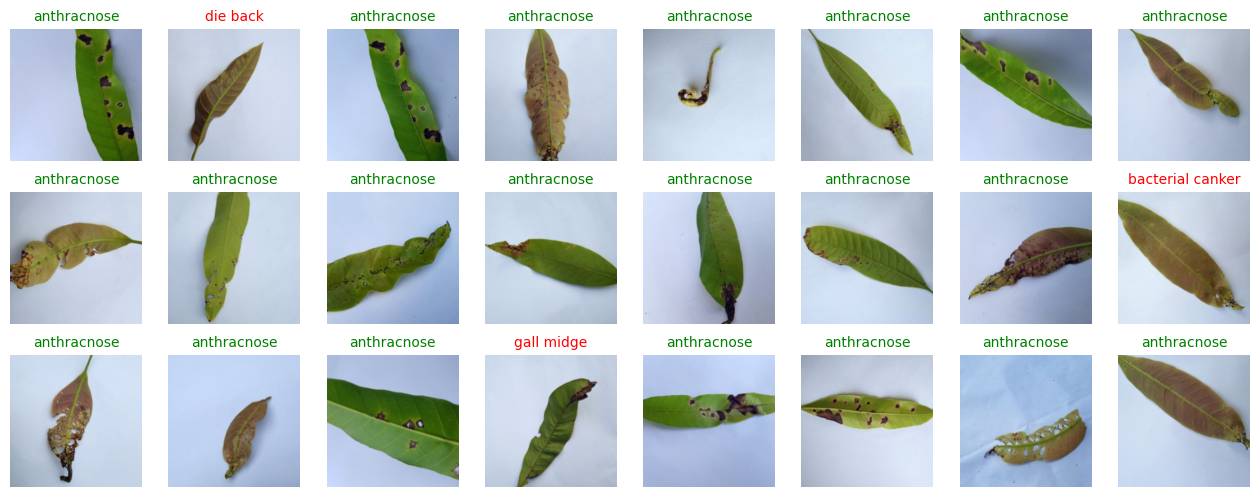

In [54]:
def plot_predictions_images(images_and_classes,
                            labels_true, labels_pred,
                            cols=5):
    rows = 3
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image, label_true, label_pred) in enumerate(zip(images_and_classes, labels_true.astype("int32"), labels_pred)):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        image = normalize_image(image)
        plt.imshow(image.permute(1, 2, 0).cpu().numpy())
        plt.title(class_names[label_pred], color ='g' if label_true == label_pred else 'r', fontsize=10 )

plot_predictions_images(images[:24], labels[:24], preds[:24], cols=8)


From the above visualization the images that has a `red` title are `mis-classified` by the model and the one in `green` was classified well by the model.


### The confusion matrix

Let's create a confusion matrix as a way of visualizing how good our model is when it comes to predicting images in the `test` set. We are going to use a function called `plot_complicated_confusion_matrix` from `helperfns.visualization` in the following code cell, this function will take in the `real-labels`, `predicted labels` together with the classes (textual labels e.g, Nevus)

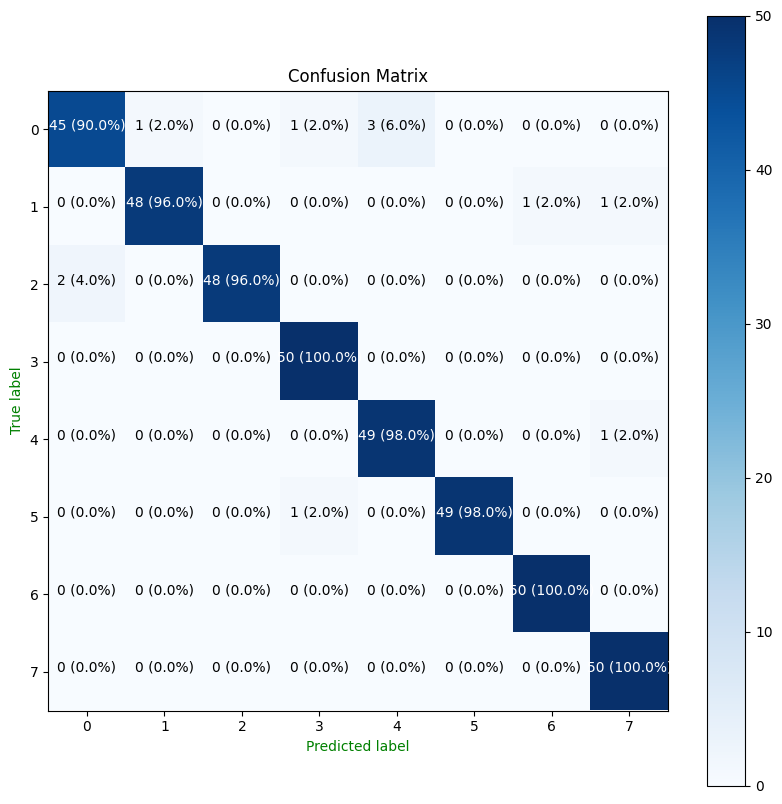

In [55]:
plot_complicated_confusion_matrix(labels, preds, np.arange(8), fontsize=10, figsize=(10, 10), )

### Classification report

In the following code cell we are going to print the classification report as a way of measuring how good our model was in predicting (benign and malignant) melenoma skin cancers.

In [56]:
cr = classification_report(labels, preds, output_dict=False)
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.90      0.93        50
           1       0.98      0.96      0.97        50
           2       1.00      0.96      0.98        50
           3       0.96      1.00      0.98        50
           4       0.94      0.98      0.96        50
           5       1.00      0.98      0.99        50
           6       0.98      1.00      0.99        50
           7       0.96      1.00      0.98        50

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



### F1 Score
`F1 score` is a machine learning evaluation metric that measures a model's accuracy. It combines the `precision` and `recall` scores of a model. The accuracy metric computes how many times a model made a correct prediction across the entire dataset.


In the following code cell we are going to calculate the `f1_score` of the model in the test dataset.

In [57]:
score = f1_score(labels, preds, labels=np.arange(8, dtype=np.float32), average=None)
score

array([0.92783505, 0.96969697, 0.97959184, 0.98039216, 0.96078431,
       0.98989899, 0.99009901, 0.98039216])

### Precision Score

`Precision` score measures the proportion of positively predicted labels that are actually correct. Precision is also known as the positive predictive value.


Let's check the precision score of our classifier based on our examples on the test set.

In [58]:
precision = precision_score(labels, preds, labels=np.arange(8, dtype=np.float32), average=None)
precision

array([0.95744681, 0.97959184, 1.        , 0.96153846, 0.94230769,
       1.        , 0.98039216, 0.96153846])

### Recall Score

Recall score is used to measure the model performance in terms of measuring the count of true positives in a correct manner out of all the actual positive values.

In [59]:
recall = recall_score(labels, preds, labels=np.arange(8, dtype=np.float32), average=None)
recall

array([0.9 , 0.96, 0.96, 1.  , 0.98, 0.98, 1.  , 1.  ])

#### Refs

The following links references to resources that was used in this notebook:


1. [www.kaggle.com/datasets](https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset)
2. [03_Torch_Vision/03_Image_Classification/04_VGG](https://github.com/CrispenGari/pytorch-python/blob/main/03_Torch_Vision/03_Image_Classification/04_VGG.ipynb)
3. [03_Torch_Vision/03_Image_Classification/05_ResNet](https://github.com/CrispenGari/pytorch-python/blob/main/03_Torch_Vision/03_Image_Classification/05_ResNet.ipynb)
4. [github/bentrevett](https://nbviewer.org/github/bentrevett/pytorch-image-classification/blob/master/5_resnet.ipynb)